# The Goal
- Branching off of previous results, fix imbalance in data set
- Explore / compare resulting model performance of using random under-sampling vs random over-sampling.

# Step 1: reproduce imbalance from original dataset split
- Note: This <a href='https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/data'>data set from kaggle</a> contains features that went through a PCA transformation

In [26]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import collections
import logging
import os
import sys
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

Reproducing results from baseline model by reusing seed of 1234

In [2]:
df = pd.read_csv('./creditcard.csv')
X = df.drop('Class', axis=1).values
Y = df.Class.values

seed = 1234
tf.random.set_seed(seed)

x, x_test, y, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=seed)
x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=seed)

print(f'original dataset: {x.shape[0]} examples, {x.shape[1]} features')
print(f'training set: {x_train.shape[0]} examples, {round(100 * x_train.shape[0] / X.shape[0])}%')
print(f'validation set: {x_cv.shape[0]} examples, {round(100 * x_cv.shape[0] / X.shape[0])}%')
print(f'test set: {x_test.shape[0]} examples, {round(100 * x_test.shape[0] / X.shape[0])}%')
print('======================================')
print(f'positive examples split:')
print(f'training set: {round(len(y_train[y_train==1]) / len(Y[Y==1]) * 100)}%')
print(f'cv set: {round(len(y_test[y_test==1]) / len(Y[Y==1]) * 100)}%')
print(f'test set: {round(len(y_cv[y_cv==1]) / len(Y[Y==1]) * 100)}%')
print('======================================')
print(f'positive example percentage within sets:')
print(f'training set: {round(len(y_train[y_train==1]) / len(y_train) * 100, 3)}% positive examples')
print(f'cv set: {round(len(y_cv[y_cv==1]) / len(y_cv) * 100, 3)}% positive examples')
print(f'test set: {round(len(y_test[y_test==1]) / len(y_test) * 100, 3)}% positive examples')

original dataset: 242085 examples, 30 features
training set: 205772 examples, 72%
validation set: 36313 examples, 13%
test set: 42722 examples, 15%
positive examples split:
training set: 74%
cv set: 16%
test set: 10%
positive example percentage within sets:
training set: 0.176% positive examples
cv set: 0.132% positive examples
test set: 0.19% positive examples


## Step 2: Apply random undersampling to training set
Applying undersampling / oversampling techniques to both the test/cv sets can cause duplicate examples across train/test sets.

In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=seed, replacement=True)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

print(f'positive example percentage within sets:')
print(f'original training set: {round(len(y_train[y_train==1]) / len(y_train) * 100, 3)}% ({len(y_train[y_train==1])} out of {len(y_train)}) positive examples')
print(f'random under sampled training set: {round(len(y_train_rus[y_train_rus==1]) / len(y_train_rus) * 100, 3)}% ({len(y_train_rus[y_train_rus==1])} out of {len(y_train_rus)}) positive examples')

positive example percentage within sets:
original training set: 0.176% (363 out of 205772) positive examples
random under sampled training set: 50.0% (363 out of 726) positive examples


## Step 3: Apply random oversampling to training set

In [5]:
ros = RandomOverSampler(random_state=seed)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

print(f'positive example percentage within sets:')
print(f'original training set: {round(len(y_train[y_train==1]) / len(y_train) * 100, 3)}% ({len(y_train[y_train==1])} out of {len(y_train)}) positive examples')
print(f'random over sampled training set: {round(len(y_train_ros[y_train_ros==1]) / len(y_train_ros) * 100, 3)}% ({len(y_train_ros[y_train_ros==1])} out of {len(y_train_ros)}) positive examples')

positive example percentage within sets:
original training set: 0.176% (363 out of 205772) positive examples
random over sampled training set: 50.0% (205409 out of 410818) positive examples


# Step 4: Train logistic regression, NN, and xgboost on undersampled training set
- Undersampling fixes the imbalance problem, but it is uncertain whether the benefits of balance will outweigh the loss of training examples.

In [25]:
## logistic regression

# building model framework
lgmodel_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lgmodel_v2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_lgmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)

logging.getLogger("tensorflow").setLevel(logging.ERROR)

lgmodel_v2.fit(
    x_train_rus, y_train_rus,
    epochs=50,
    callbacks = [tensorboard],
    validation_data = (x_cv, y_cv),
)

sys.stdout = open(f'./logs/{NAME}/config.txt', 'w')
print(lgmodel_v2.summary())
print(lgmodel_v2.to_json())

In [21]:
%load_ext tensorboard
%tensorboard --logdir logs/{NAME}

In [22]:
## NN

# building model framework
nnmodel_v2 = tf.keras.models.Sequential([
        Dense(units=x_train.shape[1], activation='relu'),
        Dense(units=15, activation='relu'),
        Dense(units=5, activation='relu'),
        Dense(units=1, activation='sigmoid'),
])

nnmodel_v2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_nnmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)

logging.getLogger("tensorflow").setLevel(logging.ERROR)

nnmodel_v2.fit(
    x_train_rus, y_train_rus,
    epochs=50,
    callbacks = [tensorboard],
    validation_data = (x_cv, y_cv),
)

sys.stdout = open(f'./logs/{NAME}/config.txt', 'w')
print(nnmodel_v2.summary())
print(nnmodel_v2.to_json())

In [28]:
%load_ext tensorboard
%tensorboard --logdir logs/{NAME}

Reusing TensorBoard on port 6014 (pid 24458), started 0:00:43 ago. (Use '!kill 24458' to kill it.)

In [29]:
## xgboost

xgbmodel_v2 = XGBClassifier(n_estimators=100)
xgbmodel_v2.fit(x_train_rus, y_train_rus)


/Users/solinakim/opt/anaconda3/envs/mypython3.6/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Step 5: Repeat training with over sampled training set

In [32]:
## logistic regression

# building moddel framework
lgmodel_v3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lgmodel_v3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_lgmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)

logging.getLogger("tensorflow").setLevel(logging.ERROR)

lgmodel_v3.fit(
    x_train_ros, y_train_ros,
    epochs=50,
    callbacks = [tensorboard],
    validation_data = (x_cv, y_cv),
)

sys.stdout = open(f'./logs/{NAME}/config.txt', 'w')
print(lgmodel_v3.summary())
print(lgmodel_v3.to_json())

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/{NAME}

In [33]:
## NN

# building model framework
nnmodel_v3 = tf.keras.models.Sequential([
        Dense(units=25, activation='relu'),
        Dense(units=15, activation='relu'),
        Dense(units=5, activation='relu'),
        Dense(units=1, activation='sigmoid'),
])

nnmodel_v3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_nnmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)

logging.getLogger("tensorflow").setLevel(logging.ERROR)

nnmodel_v3.fit(
    x_train_ros, y_train_ros,
    epochs=50,
    callbacks = [tensorboard],
    validation_data = (x_cv, y_cv),
)

sys.stdout = open(f'./logs/{NAME}/config.txt', 'w')
print(nnmodel_v3.summary())
print(nnmodel_v3.to_json())

In [35]:
%load_ext tensorboard
%tensorboard --logdir logs/{NAME}

Reusing TensorBoard on port 6012 (pid 24827), started 0:00:02 ago. (Use '!kill 24827' to kill it.)

In [36]:
## xgboost

xgbmodel_v3 = XGBClassifier(n_estimators=100)
xgbmodel_v3.fit(x_train_ros, y_train_ros)


/Users/solinakim/opt/anaconda3/envs/mypython3.6/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Step 6: Compare Results

In [20]:
# predictions
# random undersampling

lgmodel_v2_cv_pred_probs = lgmodel_v2.predict(x_cv)
nnmodel_v2_cv_pred_probs = nnmodel_v2.predict(x_cv)
xgbmodel_v2_cv_preds = xgbmodel_v2.predict(x_cv)

#random oversampling
lgmodel_v3_cv_pred_probs = lgmodel_v3.predict(x_cv)
nnmodel_v3_cv_pred_probs = nnmodel_v3.predict(x_cv)
xgbmodel_v3_cv_preds = xgbmodel_v3.predict(x_cv)

# converting probabilities from sigmoid to binary classes
binclass_threshold = 0.5
lgmodel_v2_cv_preds = (lgmodel_v2_cv_pred_probs >= binclass_threshold).astype(int)
nnmodel_v2_cv_preds = (nnmodel_v2_cv_pred_probs >= binclass_threshold).astype(int)
lgmodel_v3_cv_preds = (lgmodel_v3_cv_pred_probs >= binclass_threshold).astype(int)
nnmodel_v3_cv_preds = (nnmodel_v3_cv_pred_probs >= binclass_threshold).astype(int)

# generating confusion matrices
cm_lgmodel_v2 = confusion_matrix(y_cv, lgmodel_v2_cv_preds)
cm_nnmodel_v2 = confusion_matrix(y_cv, nnmodel_v2_cv_preds)
cm_xgbmodel_v2 = confusion_matrix(y_cv, xgbmodel_v2_cv_preds)

cm_lgmodel_v3 = confusion_matrix(y_cv, lgmodel_v3_cv_preds)
cm_nnmodel_v3 = confusion_matrix(y_cv, nnmodel_v3_cv_preds)
cm_xgbmodel_v3 = confusion_matrix(y_cv, xgbmodel_v3_cv_preds)

'========F1 SCORES========'

'========with random undersampling'

'logistic regression: 0.0026814144461203286'

'neural networks: 0.002640627148947875'

'xgboost: 0.06540697674418605'

'========with random oversampling'

'logistic regression: 0.15492957746478875'

'neural networks: 0.0'

'xgboost: 0.8936170212765957'

'========RECEIVER OPERATING CHARACTERISTIC CURVE (ROC AUC)========'

'========with random undersampling'

'logistic regression: 0.507707155659727'

'neural networks: 0.5000827243899076'

'xgboost 0.9510607679580863'

'========with random oversampling'

'logistic regression: 0.9517705317339951'

'neural networks: 0.5'

'xgboost 0.9374448504067283'

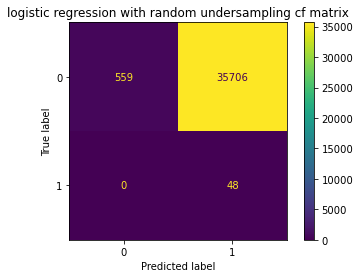

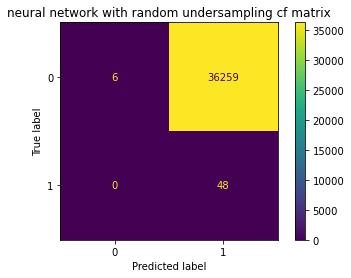

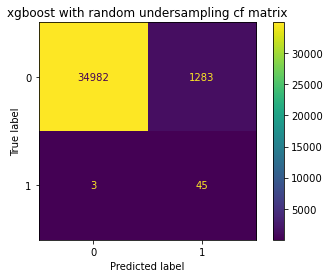

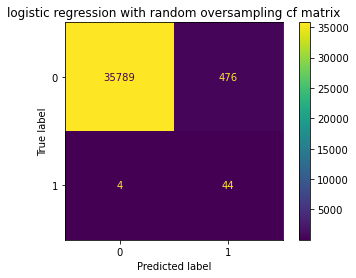

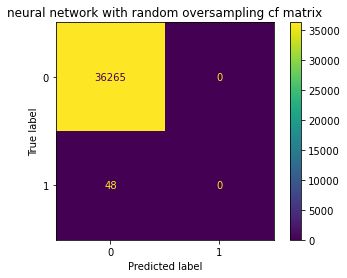

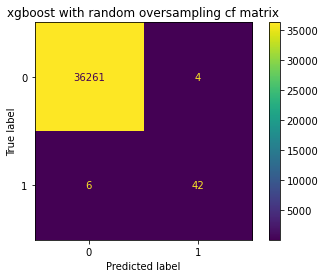

In [21]:
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm_lgmodel_v2)
dp1.plot()
dp1.ax_.set_title('logistic regression with random undersampling cf matrix')

dp2 = ConfusionMatrixDisplay(confusion_matrix=cm_nnmodel_v2)
dp2.plot()
dp2.ax_.set_title('neural network with random undersampling cf matrix')

dp3 = ConfusionMatrixDisplay(confusion_matrix=cm_xgbmodel_v2)
dp3.plot()
dp3.ax_.set_title('xgboost with random undersampling cf matrix')

dp4 = ConfusionMatrixDisplay(confusion_matrix=cm_lgmodel_v3)
dp4.plot()
dp4.ax_.set_title('logistic regression with random oversampling cf matrix')

dp5 = ConfusionMatrixDisplay(confusion_matrix=cm_nnmodel_v3)
dp5.plot()
dp5.ax_.set_title('neural network with random oversampling cf matrix')

dp6 = ConfusionMatrixDisplay(confusion_matrix=cm_xgbmodel_v3)
dp6.plot()
dp6.ax_.set_title('xgboost with random oversampling cf matrix')

# f1 scores
display('========F1 SCORES========')
display('========with random undersampling')
display(f'logistic regression: {f1_score(y_cv, lgmodel_v2_cv_preds)}')
display(f'neural networks: {f1_score(y_cv, nnmodel_v2_cv_preds)}')
display(f'xgboost: {f1_score(y_cv, xgbmodel_v2_cv_preds)}')
display('========with random oversampling')
display(f'logistic regression: {f1_score(y_cv, lgmodel_v3_cv_preds)}')
display(f'neural networks: {f1_score(y_cv, nnmodel_v3_cv_preds)}')
display(f'xgboost: {f1_score(y_cv, xgbmodel_v3_cv_preds)}')

# roc-auc scores
display('========RECEIVER OPERATING CHARACTERISTIC CURVE (ROC AUC)========')
display('========with random undersampling')
display(f'logistic regression: {roc_auc_score(y_cv, lgmodel_v2_cv_preds)}')
display(f'neural networks: {roc_auc_score(y_cv, nnmodel_v2_cv_preds)}')
display(f'xgboost {roc_auc_score(y_cv, xgbmodel_v2_cv_preds)}')

display('========with random oversampling')
display(f'logistic regression: {roc_auc_score(y_cv, lgmodel_v3_cv_preds)}')
display(f'neural networks: {roc_auc_score(y_cv, nnmodel_v3_cv_preds)}')
display(f'xgboost {roc_auc_score(y_cv, xgbmodel_v3_cv_preds)}')

In [43]:
lgmodel_v2.save('./models/lgmodel_v2')
nnmodel_v2.save('./models/nnmodel_v2')
xgbmodel_v2.save_model('./models/xgbmodel_v2.json')
lgmodel_v3.save('./models/lgmodel_v3')
nnmodel_v3.save('./models/nnmodel_v3')
xgbmodel_v3.save_model('./models/xgbmodel_v3.json')

In [11]:
# continuing session by reloading same models as above
# to prevent having to train models again

lgmodel_v2 = tf.keras.models.load_model('./models/lgmodel_v2')
nnmodel_v2 = tf.keras.models.load_model('./models/nnmodel_v2')
xgbmodel_v2 = XGBClassifier()
xgbmodel_v2.load_model('./models/xgbmodel_v2.json')
lgmodel_v3 = tf.keras.models.load_model('./models/lgmodel_v3')
nnmodel_v3 = tf.keras.models.load_model('./models/nnmodel_v3')
xgbmodel_v3 = XGBClassifier()
xgbmodel_v3.load_model('./models/xgbmodel_v3.json')



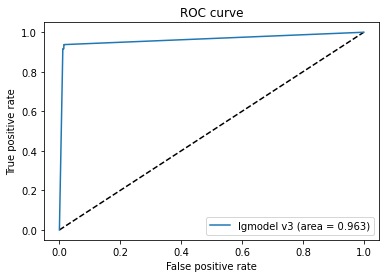

In [25]:
lgmodel_v3_cv_fpr, lgmodel_v3_cv_tpr, thresholds = roc_curve(y_cv, lgmodel_v3_cv_pred_probs)
lgmodel_v3_auc = auc(lgmodel_v3_cv_fpr, lgmodel_v3_cv_tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lgmodel_v3_cv_fpr, lgmodel_v3_cv_tpr, label='lgmodel v3 (area = {:.3f})'.format(lgmodel_v3_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Conclusion
- All models performed worse (lower F1 and AUC scores) with random undrsampling. This seems to be due to reduced training set size (< 100)
- Random oversampling produced higher F1 and AUC scores of approx 1% for xgboost model.
- Random oversampling produced higher AUC score but lower F1 score for logistic regression, indicating that a change in threshold may improve results. It can also mean that the model is overfitting the added positive examples, which can be improved with regularization.
- For the neural network, random undrsampling showed some activity for the first time, with a F1 score slightly above 0 and AUC score slightly above 0.5 (0 and 0.5 are equivalent to no performance). This can mean that the NN has been overfitting to the negative training examples.

# Next steps:
- Continuing the oversampling approach, try to improve training data quality with SMOTE oversampling.
- Try to improve logistic regression model by using a higher threshold and regularization.
- Try to improve neural network by using regularization and smaller epoch.